In [145]:
import os
import sys
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage
import scipy.spatial as spatial
import numpy as np
import pandas as pd

import tifffile as tf
import citrus_utils as vitaminC

In [2]:
reload(vitaminC)

<module 'citrus_utils' from '/home/ejam/documents/citrus/citrus/citrus_utils.py'>

In [89]:
init_src = '../preproc/tissue/'
ctrs_src = sorted(glob.glob(init_src + 'SW*/'))
ctrs_src

['../preproc/tissue/SW01_CRC3030_12B-8-5/',
 '../preproc/tissue/SW02_CRC3746_12B-17-7/',
 '../preproc/tissue/SW03_CRC1241-B_12B-4-3/',
 '../preproc/tissue/SW04_CRC2802_12B-11-5/',
 '../preproc/tissue/SW05_CRC3994_12A-25-9/']

In [90]:
src = ctrs_src[3]
L = 2
init_dst = '../preproc/oil/'

bname = src.split('/')[-2]
lname = 'L{:02d}'.format(L)

filename = src+ lname + '/'+ bname + '_' + lname + '_exocarp.tif'

dst = init_dst + bname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
dst += lname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print(dst)

print(filename)
exo = tf.imread(filename).astype(np.uint8)
print(exo.shape)

../preproc/oil/SW04_CRC2802_12B-11-5/L02/
../preproc/tissue/SW04_CRC2802_12B-11-5/L02/SW04_CRC2802_12B-11-5_L02_exocarp.tif
(724, 689, 690)


[(inf, None, 208), (181354, 191, 177), (1, 238, 239), (0, 247, 254)]
202


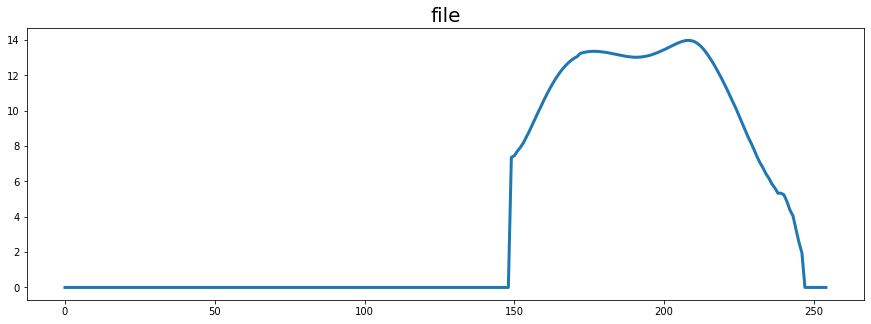

In [58]:
thr = vitaminC.get_individual_threshold(exo, True)
print(thr)

In [59]:
thr = 207

remove = 10
gtglands = exo.copy()
ltglands = exo.copy()
gtglands[gtglands < thr] = 0
ltglands[ltglands >= thr] = 0
ltglands[ltglands < remove] = 0
#gtglands[gtglands > 0] = 1
#gtglands = ndimage.binary_dilation(gtglands, iterations=2, structure=struc)

In [60]:
struc = ndimage.generate_binary_structure(exo.ndim, 1)
size = 9
cglands = gtglands.copy()
cglands = ndimage.grey_closing(cglands, size=(size,size,size), mode='constant')
#cglands = ndimage.grey_erosion(cglands, size=(3,3,3), mode='constant')
#cglands = ndimage.grey_opening(cglands, structure=struc, mode='constant')

In [61]:
mskglands = cglands.copy()
mskglands[mskglands > 0] = 1
lglands = ltglands*mskglands
print(np.sum(lglands > 0))

5722114


In [62]:
oiters = 1
ooilglands = lglands.copy()
ooilglands = ndimage.binary_opening(ooilglands, structure=struc, iterations=oiters)

oilglands = ooilglands*exo
print(np.sum(oilglands > 0))

3719588


2 3


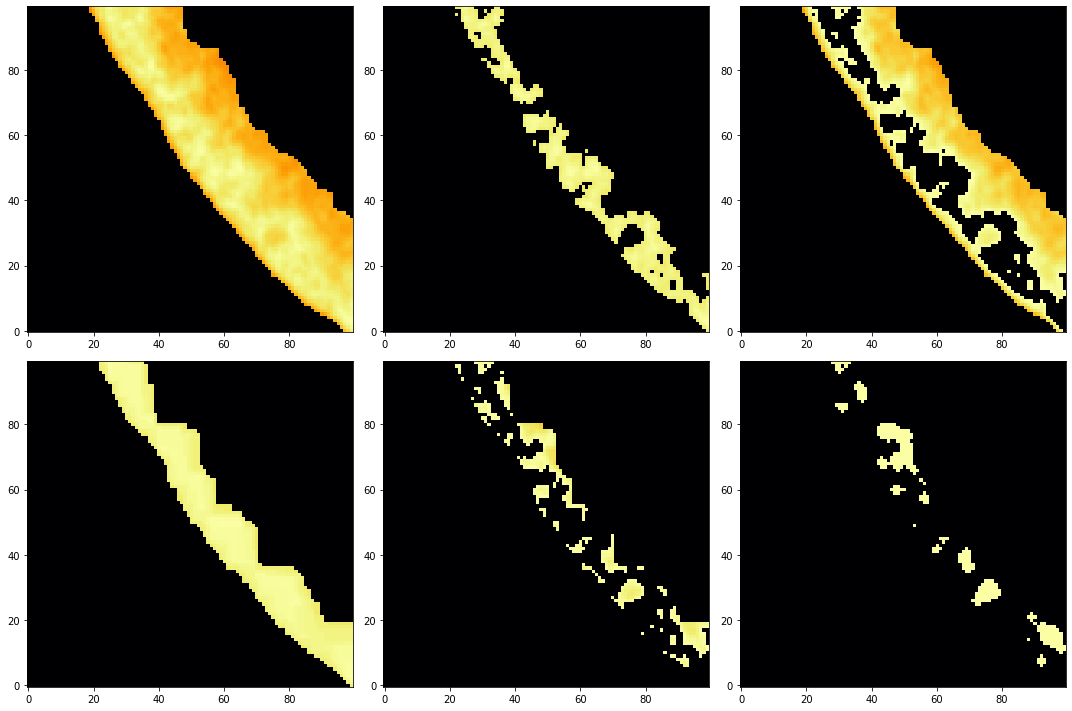

In [63]:
k = 350
ss = np.s_[100:200, k, 25:125]
#ss = np.s_[:,k,:]
vitaminC.plot4x4panel([exo, gtglands, ltglands, cglands, lglands, ooilglands], ss, bname=bname)

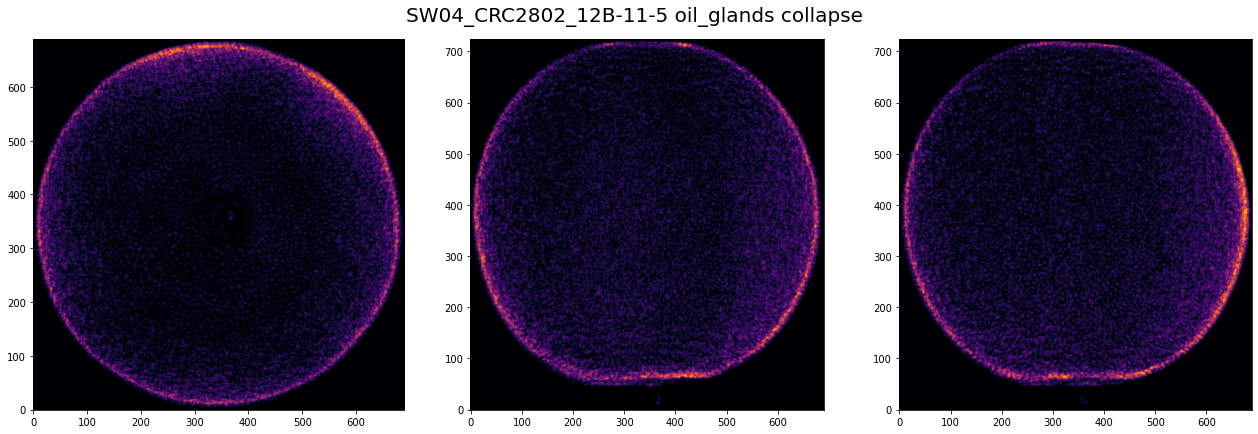

In [64]:
writefig = False
display  = True
diag_dst = init_dst + bname + '/'
snaps = vitaminC.collapse_dimensions(oilglands)
vitaminC.plot_collapse_dimensions(snaps, bname, 'oil_glands', display=display, writefig=writefig, dst=diag_dst)

## Clean up the oil gland clumps and get centers

In [65]:
labels,num = ndimage.label(oilglands, structure=struc)
print(num,'components')
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(hist[argsort_hist][:20])
print(np.median(hist))
print(np.mean(hist))
print(np.min(hist))
print(np.std(hist))

minsize = 3*np.min(hist)

new_hist = hist[hist > minsize]
maxsize = 3*np.median(new_hist)

print('maxsize',maxsize)

above_out = np.sum(hist > maxsize)
print('above_out',above_out)

below_out = np.sum(hist < minsize)
print('below_out', below_out)

print('Oil Glands = ', num - np.sum(hist<minsize))

14793 components
[1153560  198267   43225   42333   34952   21886   21637   20095   19047
   18403   16833   15694   15166   14615   12642   11856   10876   10206
   10125    9993]
29.0
251.44243899141486
7
9661.935662294929
maxsize 294.0
above_out 1307
below_out 6395
Oil Glands =  8398


In [66]:
npz = np.hstack(([0],1+np.argsort(argsort_hist)))

with np.nditer(labels, flags=['external_loop'], op_flags=['readwrite']) as it:
    for x in it:
        x[...] = npz[x]
        
binglands = oilglands.copy()
binglands[binglands > 0] = 1

normalsized = np.arange(above_out, num-below_out+1)
largesized = np.arange(1, above_out)
smallsized = np.arange(num - below_out+1, num+1)

In [67]:
center_mass_normal = np.array(ndimage.center_of_mass(binglands, labels=labels, index=normalsized))
binglands[labels >= above_out] = 0

In [68]:
iters = oiters
largesized1 = largesized
above_out1 = 10
center_list = [center_mass_normal]
numgeq1 = True

obinglands = binglands.copy()
glands_tif = oilglands.copy()
glands_tif[glands_tif > 0] = 1
glands_tif[labels > num - below_out] = 0
glands_tif[labels < above_out] = 0

print('np.sum(binglands > 0)', np.sum(obinglands > 0))

while numgeq1 and above_out1 > 0 and (iters < 10):
    print('---\nIteration:',iters)
    iters += 1
    obinglands, labels1, normalsized1, largesized1, numgeq1 = vitaminC.refine_oil_gland(obinglands, maxsize, minsize, iters)
    if numgeq1 and len(normalsized1) > 0:
        center_mass_broken = np.array(ndimage.center_of_mass(obinglands, labels=labels1, index=normalsized1))
        center_list.append(center_mass_broken)
    
        above_out1 = len(largesized1)
        obinglands[labels1 >= above_out1] = 0
        print('np.sum(binglands > 0):', np.sum(obinglands > 0))



        glands_tif[labels1 > above_out1] = 1

np.sum(binglands > 0) 2961053
---
Iteration: 1
7242 components
[5764 5367 4837 4437 4164 3374 3371 3295 3174 3171 3064 2978 2912 2809
 2734 2726 2647 2587 2552 2518]
above_out 1128
below_out 0
6114 1128
np.sum(binglands > 0): 681308
---
Iteration: 2
1281 components
[1479 1222 1159 1072  991  937  854  836  777  774  765  746  715  660
  656  655  632  630  611  599]
above_out 165
below_out 0
1116 165
np.sum(binglands > 0): 73821
---
Iteration: 3
77 components
[651 483 476 377 368 336 324 305 260 260 255 250 245 236 235 235 235 235
 231 227]
above_out 8
below_out 0
69 8
np.sum(binglands > 0): 3015
---
Iteration: 4
1 components


In [69]:
print(len(normalsized))
center_mass = np.vstack(center_list)
center_mass.shape

7092


(14391, 3)

In [70]:
center_mass = center_mass[~np.isnan(center_mass[:,0]),:]
center_mass.shape

(14391, 3)

In [71]:
filename = dst + bname + '_glandscenter.csv'
print(filename)
np.savetxt(filename, center_mass, fmt='%d', delimiter=',')

../preproc/oil/SW04_CRC2802_12B-11-5/L02/SW04_CRC2802_12B-11-5_glandscenter.csv


## Clean up the oil gland clumps and get a nice image

In [72]:
clean_glands = exo*glands_tif

In [73]:
filename = dst + bname + '_glands.tif'
print(filename)
tf.imwrite(filename, clean_glands, photometric='minisblack', compress=3)

../preproc/oil/SW04_CRC2802_12B-11-5/L02/SW04_CRC2802_12B-11-5_glands.tif


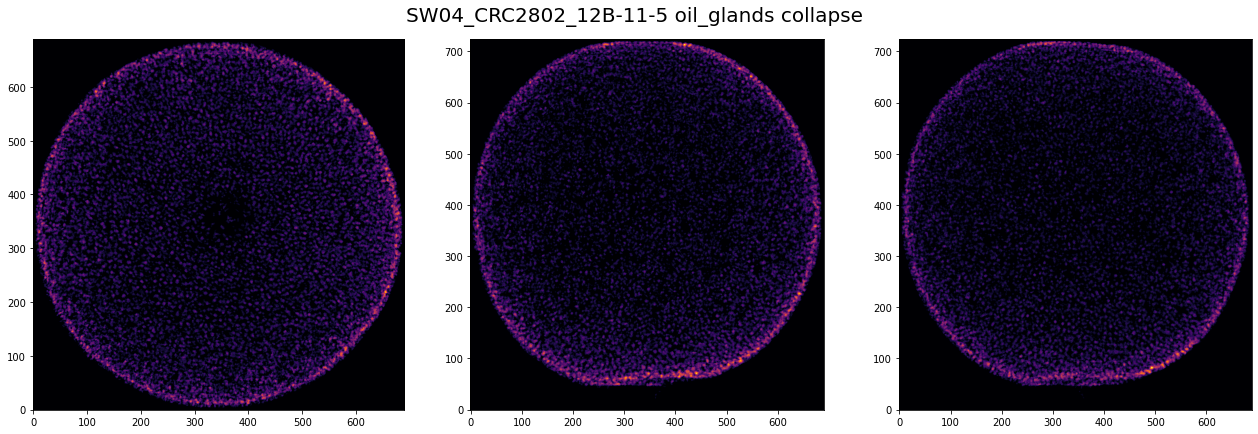

In [74]:
writefig = True
display  = True
diag_dst = init_dst + bname + '/L{:02d}_'.format(L)
snaps = vitaminC.collapse_dimensions(clean_glands)
vitaminC.plot_collapse_dimensions(snaps, bname, 'oil_glands', display=display, writefig=writefig, dst=diag_dst)

# 11*1.29

In [5]:
filename = dst + bname + '_glands.tif'
print(filename)
glands = tf.imread(filename)

../preproc/oil/SW04_CRC2802_12B-11-5/L02/SW04_CRC2802_12B-11-5_glands.tif


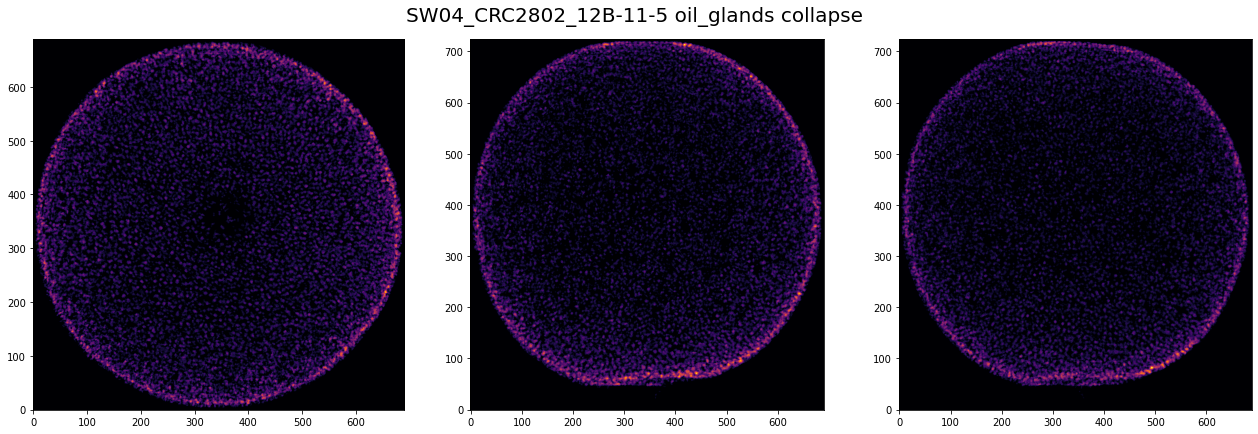

In [7]:
diag_dst = init_dst + bname + '/L{:02d}_'.format(L)
snaps = vitaminC.collapse_dimensions(glands)
vitaminC.plot_collapse_dimensions(snaps, bname, 'oil_glands')

In [73]:
exo.shape

(724, 689, 690)

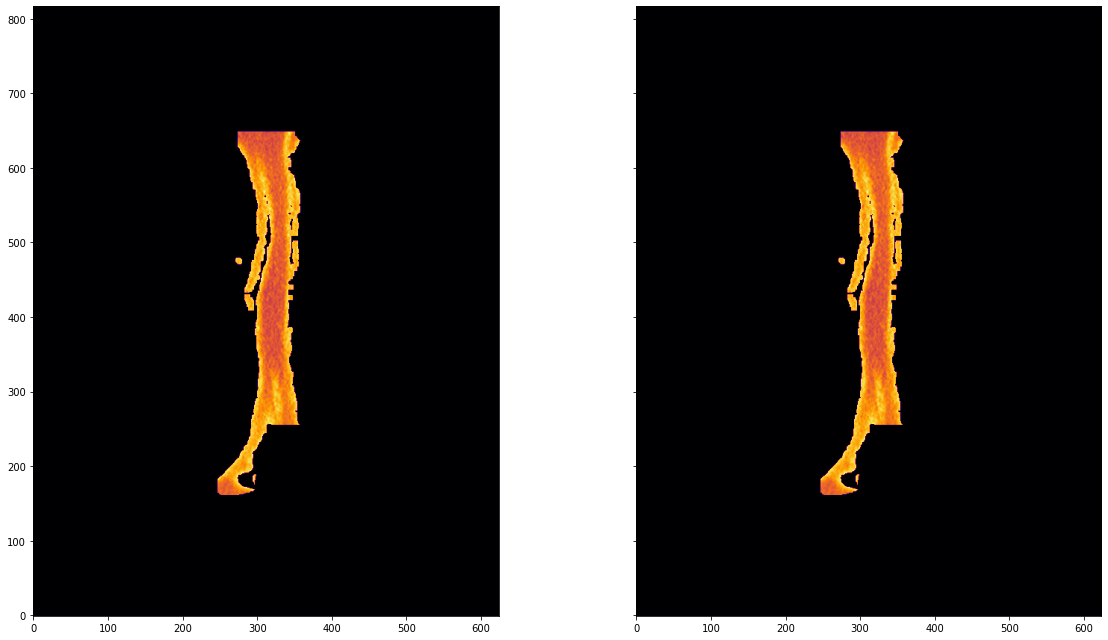

In [118]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(18,9))

k = 300
ss = np.s_[:, k, :]

foo = spine[ss].astype(np.uint16)# - (0.5*glands[ss]).astype(np.uint16)
ax[0].imshow(spine[ss], cmap='inferno', origin='lower')
ax[1].imshow(foo, cmap='inferno', origin='lower')

fig.tight_layout();

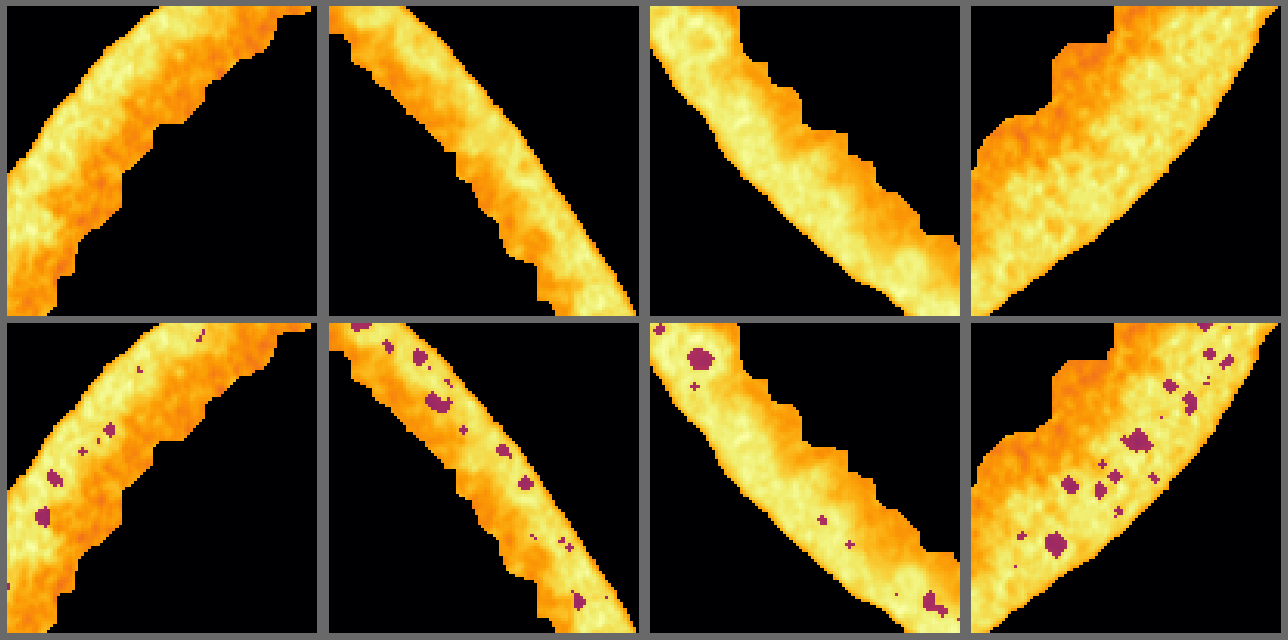

In [144]:
fig, ax = plt.subplots(2,4,sharex=True, sharey=True, figsize=(18,9), facecolor='dimgray')

k = 150
ss = np.s_[500:600, k, 100:200]

foo = exo[ss].astype(np.uint16) - (0.5*glands[ss]).astype(np.uint16)
ax[0,0].imshow(exo[ss], cmap='inferno', origin='lower')
ax[1,0].imshow(foo, cmap='inferno', origin='lower')

#k = 225
#ss = np.s_[615:715, k, 290:390]
#foo = exo[ss].astype(np.uint16) - (0.5*glands[ss]).astype(np.uint16)
#ax[0,1].imshow(exo[ss], cmap='inferno', origin='lower')
#ax[1,1].imshow(foo, cmap='inferno', origin='lower')

k = 300
ss = np.s_[540:640, k, 550:650]
foo = exo[ss].astype(np.uint16) - (0.5*glands[ss]).astype(np.uint16)
ax[0,1].imshow(exo[ss], cmap='inferno', origin='lower')
ax[1,1].imshow(foo, cmap='inferno', origin='lower')

k = 450
ss = np.s_[100:200, k, 70:170]
foo = exo[ss].astype(np.uint16) - (0.5*glands[ss]).astype(np.uint16)
ax[0,2].imshow(exo[ss], cmap='inferno', origin='lower')
ax[1,2].imshow(foo, cmap='inferno', origin='lower')

#k = 525
#ss = np.s_[75:175, k, 290:390]
#foo = exo[ss].astype(np.uint16) - (0.5*glands[ss]).astype(np.uint16)
#ax[0,4].imshow(exo[ss], cmap='inferno', origin='lower')
#ax[1,4].imshow(foo, cmap='inferno', origin='lower')

k = 600
ss = np.s_[175:275, k, 450:550]

foo = exo[ss].astype(np.uint16) - (0.5*glands[ss]).astype(np.uint16)
ax[0,3].imshow(exo[ss], cmap='inferno', origin='lower')
ax[1,3].imshow(foo, cmap='inferno', origin='lower')

for a in ax.ravel():
    a.axis('off')
    
fig.tight_layout();

filename = dst + bname + '_' + lname + '_oil_closeup_2x4'
plt.savefig(filename+'.jpg', format='jpg', dpi=96, bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename+'.pdf', format='pdf')

# Plot spine

In [101]:
init_src = '../preproc/tissue/'
ctrs_src = sorted(glob.glob(init_src + 'SR*/'))
ctrs_src

['../preproc/tissue/SR01_CRC3289_12B-19-9/',
 '../preproc/tissue/SR02_CRC0628_12B-18-5/',
 '../preproc/tissue/SR03_CRC3611_12B-20-11/',
 '../preproc/tissue/SR04_CRC2717_12B-40-1/']

In [129]:
src = ctrs_src[0]
L = 1
init_dst = '../preproc/oil/'

bname = src.split('/')[-2]
lname = 'L{:02d}'.format(L)


filename = src+ lname + '/'+ bname + '_' + lname + '_spine.tif'

print(filename)
spine = tf.imread(filename).astype(np.uint8)
print(spine.shape)
coords = np.asarray(np.nonzero(spine)).T
print(coords.shape)

../preproc/tissue/SR01_CRC3289_12B-19-9/L01/SR01_CRC3289_12B-19-9_L01_spine.tif
(817, 632, 624)
(6128185, 3)


In [130]:
downsample = 3
skip = np.array([downsample,downsample,downsample])
coords = coords[np.all(np.fmod(coords, skip) == 0, axis=1), :]
print(coords.shape)
coords = coords - np.mean(coords, axis=0)

(227277, 3)


In [134]:
filename = src+ lname + '/'+ bname + '_' + lname + '_vh_alignment.csv'
vh = np.loadtxt(filename, delimiter=',')
vh

array([[-0.99886463, -0.02857418, -0.03811791],
       [ 0.04755208, -0.64630217, -0.76159852],
       [-0.00287363, -0.76254641,  0.64692713]])

In [137]:
acoords = coords @ -vh

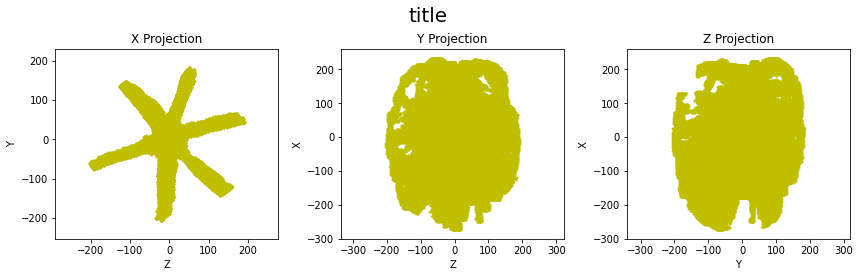

In [138]:
vitaminC.plot_3Dprojections(acoords)

In [139]:
filename = src+ lname + '/'+ bname + '_' + lname + '_spine_coords.csv'
np.savetxt(filename, acoords, delimiter=',', fmt='%.1f')